In [1]:
import os
import numpy as np
import pandas as pd
from flip import fitter, plot_utils, utils
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")

[ 000000.00 ]: 01-11 09:04  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000001.20 ]: 01-11 09:04  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000001.20 ]: 01-11 09:04  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000001.20 ]: 01-11 09:04  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000001.20 ]: 01-11 09:04  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_2208331/968461804.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import re

In [2]:
data_velocity = pd.read_parquet(os.path.join(data_path, "velocity_data.parquet"))

data_velocity_true = {"velocity": data_velocity["vpec"].values, 
                      "velocity_error": np.zeros(len(data_velocity["vpec"].values))}

coordinates_velocity = np.array([data_velocity["ra"], 
                                 data_velocity["dec"], 
                                 data_velocity["rcom_zobs"]])

ktt, ptt = np.loadtxt(os.path.join(data_path, "power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path, "power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path, "power_spectrum_mm.txt"))

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


# Fit true velocity

In [3]:
size_batch=10_000
number_worker=16


covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates_velocity,
    size_batch=size_batch,
    number_worker=number_worker,
)


[ 000019.36 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 9.95e-01 seconds


In [4]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "direct"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity_true,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter.run()


[ 000021.18 ]: 01-11 09:05  root            INFO     Iteration 1/1

[ 000025.04 ]: 01-11 09:05  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 33               │
│ EDM = 3.61e-05 (Goal: 0.0002)    │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit true velocity interpolation sigma_u

In [5]:
sigmau_list = np.linspace(10.0, 20.0,10)
covariance_list = []
size_batch=10_000
number_worker=16


for sigu in sigmau_list:
    
    power_spectrum_dict = {"vv": [[ktt, ptt* utils.Du(ktt, sigu)**2]]}

    covariance_list.append(covariance.CovMatrix.init_from_flip(
                            "carreres23",
                            "velocity",
                            power_spectrum_dict,
                            coordinates_velocity=coordinates_velocity,
                            size_batch=size_batch,
                            number_worker=number_worker,
    ))


[ 000039.84 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.03e+00 seconds
[ 000040.88 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.04e+00 seconds
[ 000041.88 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.00e+00 seconds
[ 000042.88 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.00e+00 seconds
[ 000043.91 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.02e+00 seconds
[ 000044.94 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.03e+00 seconds
[ 000046.00 ]: 01-11 09:05  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.06e+00 seconds
[ 000047.05 ]: 01-11 09:05  root            INFO     Covariance matri

In [6]:
likelihood_type="multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "direct"}

parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigu": {"value": 15.0,
                          "limit_low" : 13.0,
                          "limit_up" : 17.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        data_velocity_true,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigu",
        interpolation_value_range = sigmau_list,
)


minuit_fitter.run()


[ 000054.24 ]: 01-11 09:05  root            INFO     Iteration 1/1

[ 000101.15 ]: 01-11 09:06  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 53               │
│ EDM = 0.000168 (Goal: 0.0002)    │           time = 46.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Fit estimate velocity - do not converge for now

In [11]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky",
                         "velocity_type": "saltfit",
                         "velocity_estimator": "full",
                        }


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : True,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "limit_up" : 400,
                          "fixed" : True,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         }}

minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        data_velocity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


minuit_fitter.run()


[ 000374.77 ]: 01-11 09:11  root            INFO     Iteration 1/1

[ 000401.90 ]: 01-11 09:11  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.356e+04                  │              Nfcn = 270              │
│ EDM = 4.43e-06 (Goal: 0.0002)    │           time = 27.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

# Some plots

In [8]:
import matplotlib.pyplot as plt
plt.style.use(os.path.join(data_path,"style.mplstyle"))

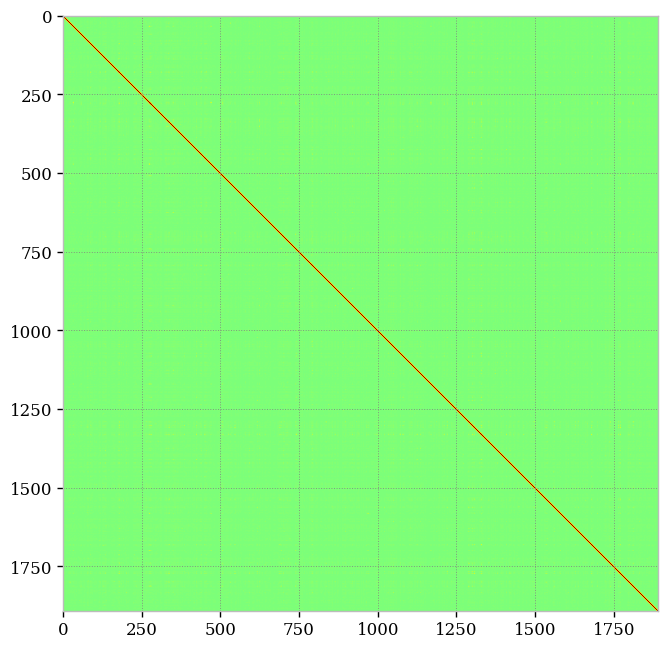

In [9]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter.likelihood,
    parameter_dict,
)

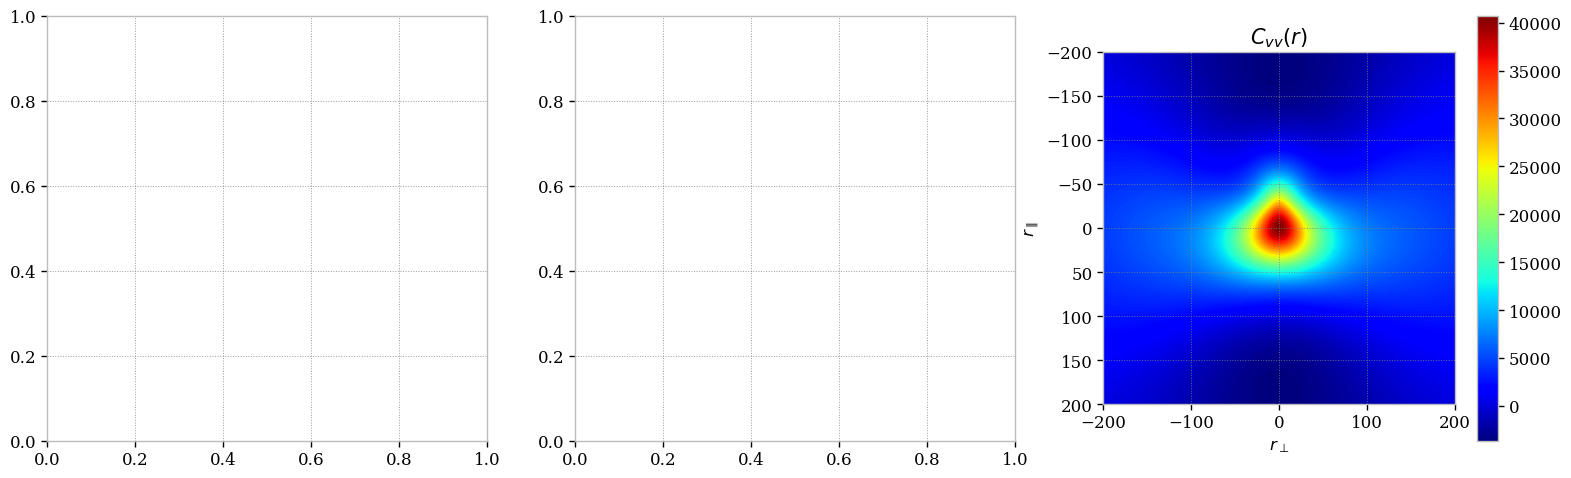

In [10]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
